<a href="https://colab.research.google.com/github/LeeSeungwon89/Kaggle_Dacon_Practice/blob/main/Titanic_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [130]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 참가한 대회 리스트를 확인합니다.
!kaggle competitions list

In [132]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [133]:
!ls

 gender_submission.csv	'kaggle (2).json'   sample_data   titanic.zip
'kaggle (1).json'	 kaggle.json	    test.csv	  train.csv


In [134]:
!unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **피처 엔지니어링**

베이스라인 모델링이므로 전체 과정을 간단하게 수행해 보겠습니다. 추후 성능 개선을 시도할 때 여러 방안을 활용하여 피처 엔지니어링과 모델링을 추가로 수행할 예정입니다.

먼저 EDA를 기반으로 피처 엔지니어링을 수행해 보겠습니다.

In [135]:
import numpy as np
import pandas as pd

pd.set_option('display.max_column', 50)
pd.set_option('display.max_rows', 50)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

# 피처 엔지니어링을 위해 훈련 및 테스트 데이터를 결합합니다.
all_data = pd.concat([train, test], ignore_index=True)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [136]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


피처 요약표를 출력하겠습니다.

In [137]:
def feature_table(df):
    # 피처 이름과 타입을 출력합니다.     
    feature_description = pd.DataFrame(df.dtypes, columns=['type'])
    feature_description = feature_description.reset_index()
    feature_description = feature_description.rename(columns={'index': 'feature'})
    # 결측치 개수를 산출합니다.
    feature_description['null count'] = df.isnull().sum().values
    # 고윳값 개수를 산출합니다.
    feature_description['eigenvalue count'] = df.nunique().values
    
    # 데이터 크기를 출력합니다.    
    print(df.shape)
    
    return feature_description

In [138]:
feature_table(all_data)

(1309, 12)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,1309
1,Survived,float64,418,2
2,Pclass,int64,0,3
3,Name,object,0,1307
4,Sex,object,0,2
5,Age,float64,263,98
6,SibSp,int64,0,7
7,Parch,int64,0,8
8,Ticket,object,0,929
9,Fare,float64,1,281


## **결측치 처리**

### **Age**

'Age' 피처의 결측치를 처리하겠습니다. 먼저 'Age' 피처의 값 분포를 확인하겠습니다.

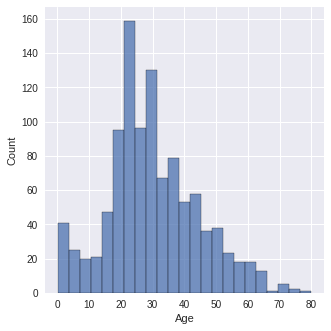

In [139]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mpl.rc('font', size=20)
plt.style.use('seaborn')

sns.displot(x='Age', data=all_data)

평균값으로 채워 보겠습니다. 전체 나이를 평균하여 채우거나 다른 피처와 그룹화하여 산출한 평균으로 채우는 방법이 있습니다. EDA에서 확인하였듯이 'Pclass' 피처(티켓 등급)별로 연령대가 다르다는 점을 확인했습니다. 특히 나이가 많을수록 티켓 등급이 높아지는 경향을 보였습니다. 따라서 'Pclass' 피처별 'Age' 피처의 평균으로 결측치를 채워 보겠습니다. 'Pclass' 피처별 'Age' 피처의 평균을 담은 데이터프레임을 만들겠습니다.

In [140]:
pclass_age_mean = all_data[['Pclass', 'Age']].groupby('Pclass').mean().reset_index()
pclass_age_mean.columns = ['Pclass', 'Age_mean']
pclass_age_mean

,Pclass,Age_mean
0,1,39.159930
1,2,29.506705
2,3,24.816367


이 데이터프레임을 원본 데이터에 병합하겠습니다.

In [141]:
all_data = pd.merge(all_data, pclass_age_mean, on='Pclass', how='left')

병합된 평균 피처를 결측치에 채우고 삭제하겠습니다.

In [142]:
all_data.loc[all_data['Age'].isnull(), 'Age'] = all_data['Age_mean']
all_data = all_data.drop('Age_mean', axis=1)

나이 분포를 확인하겠습니다.

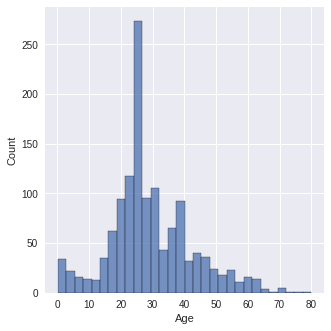

In [143]:
sns.displot(x='Age', data=all_data)

### **Fare**

'Fare' 피처의 결측치를 처리하겠습니다. 'Fare' 피처는 결측치가 1개이므로 평균값으로 채울 예정입니다. 단, 'Pclass' 피처와 'Fare' 피처간 상관관계가 크므로 전체 'Fare' 피처의 평균값이 아닌 'Pclass' 피처별 'Fare' 피처의 평균값을 채우는 편이 옳다고 판단합니다. 결측치를 채우는 방법은 위에서 평균 나이를 채웠던 방법과 같습니다. 1개만 채우면 되므로 꼭 아래 과정을 거칠 필요는 없습니다.

In [144]:
pclass_fare_mean = all_data[['Pclass', 'Fare']].groupby('Pclass').mean().reset_index()
pclass_fare_mean.columns = ['Pclass', 'Fare_mean']
pclass_fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


이 데이터프레임을 원본 데이터에 병합하겠습니다.

In [145]:
all_data = pd.merge(all_data, pclass_fare_mean, on='Pclass', how='left')

병합된 평균 피처를 결측치에 채우고 삭제하겠습니다.

In [146]:
all_data.loc[all_data['Fare'].isnull(), 'Fare'] = all_data['Fare_mean']
all_data = all_data.drop('Fare_mean', axis=1)

티켓요금 분포를 확인하겠습니다.

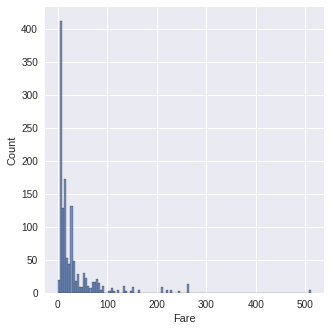

In [147]:
sns.displot(x='Fare', data=all_data)

### **Cabin**

EDA에서 'Cabin' 피처는 사용하기 부적절하여 제거하는 편이 낫다는 판단을 내렸습니다. 제거하겠습니다.

In [148]:
all_data = all_data.drop('Cabin', axis=1)

### **Embarked**

마지막으로 'Embarked' 피처는 명목형 피처이므로 최빈값으로 대체해 보겠습니다. 간단한 방법을 사용하겠습니다.

In [149]:
all_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [150]:
all_data.loc[all_data['Embarked'].isnull(), 'Embarked'] = 'S'

## **파생 피처 생성**

### **Appellation**

이름에서 호칭을 분리하여 새 피처를 생성하겠습니다. 먼저 고윳값을 확인하겠습니다.

In [151]:
all_data['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

In [152]:
print(all_data['Name'].str.extract('([A-Za-z]*)\.')[0].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


EDA에서 발견하지 못한 레이블 'Dona'가 테스트 세트에 존재하는 것으로 확인됩니다. 'Dona'의 의미는 아래와 같습니다.

- Dona: 포르투갈의 귀부인 -> 'Mrs'

호칭을 분리하여 새 피처를 생성하겠습니다.

In [153]:
all_data['Appellation'] = all_data['Name'].str.extract('([A-Za-z]*)\.')

In [154]:
pd.crosstab(all_data['Sex'], all_data['Appellation'], margins=True)

Appellation,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,All
Sex,,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,466
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,843
All,1,4,1,1,1,8,1,1,2,61,260,2,1,757,197,2,8,1,1309


'Dona' 레이블은 여성 1명입니다. 'Mrs'로 치환하기에 적합합니다. 모든 레이블을 치환하겠습니다. 

In [155]:
original_label = ['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Ms', 'Rev', 'Sir']
replace_label = ['Mr', 'Mr', 'Mrs', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mrs', 'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Mr']
all_data['Appellation'].replace(original_label, replace_label, inplace=True)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

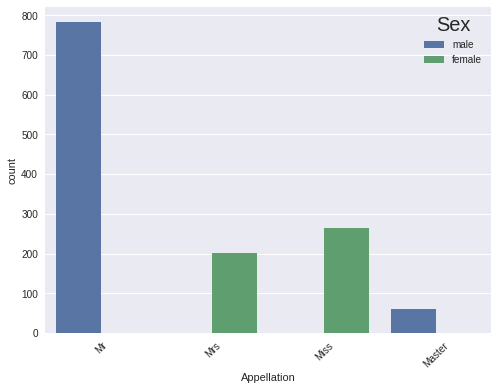

In [156]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Appellation', hue='Sex', data=all_data)
plt.xticks(rotation=45)

In [157]:
all_data.groupby('Appellation').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Appellation,,,,,,,
Master,658.852459,0.575000,2.655738,8.018212,2.049180,1.377049,36.008195
Miss,617.928030,0.702703,2.337121,22.492231,0.655303,0.496212,42.566747
Mr,658.936143,0.161710,2.348659,31.594625,0.286079,0.159642,25.370250
Mrs,687.189055,0.796875,1.920398,36.075462,0.651741,0.815920,51.068470


### **Sum_sibsp_parch**

총 가족수를 나타내는 피처를 생성하겠습니다.

In [158]:
all_data['Sum_sibsp_parch'] = all_data['SibSp'] + all_data['Parch']

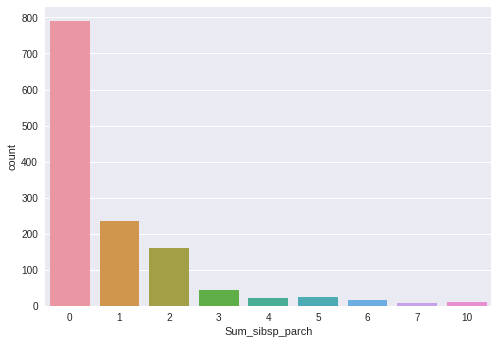

In [159]:
sns.countplot(x='Sum_sibsp_parch', data=all_data)

In [160]:
all_data.groupby('Sum_sibsp_parch').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sum_sibsp_parch,,,,,,,
0,663.743038,0.303538,2.394937,30.492801,0.000000,0.000000,21.749475
1,626.148936,0.552795,1.893617,32.177998,0.778723,0.221277,51.228106
2,687.635220,0.578431,2.226415,26.372047,0.893082,1.106918,41.566062
3,708.139535,0.724138,2.116279,19.925011,1.302326,1.697674,51.186047
4,594.272727,0.200000,2.500000,24.003720,2.000000,2.000000,80.067432
5,466.240000,0.136364,2.480000,20.120000,2.800000,2.200000,87.081000
6,547.375000,0.333333,3.000000,17.375000,3.250000,2.750000,28.396094
7,553.250000,0.000000,3.000000,18.000000,4.000000,3.000000,46.900000
10,745.000000,0.000000,3.000000,23.878516,6.727273,3.272727,69.550000


## **피처 범주화**

### **Age**

'Age' 피처는 범위가 매우 넓은 편입니다. 범위를 몇 개의 범주로 나누겠습니다. 기준은 임의로 지정하겠습니다.

In [161]:
def age_category(age):
    cat = ''
    if age <= 5:
        cat = 'Baby'
    elif age <= 12:
        cat = 'Child'
    elif age <= 19:
        cat = 'Teen'
    elif age <= 29:
        cat = 'Young'
    elif age <= 44:
        cat = 'Adult'
    elif age <= 65:
        cat = 'Middle Adult'
    else:
        cat = 'old'

    return cat

In [162]:
all_data['Age'] = all_data['Age'].map(lambda x: age_category(x))

In [163]:
all_data['Age'].value_counts()

Young           552
Adult           356
Middle Adult    166
Teen            131
Baby             56
Child            38
old              10
Name: Age, dtype: int64

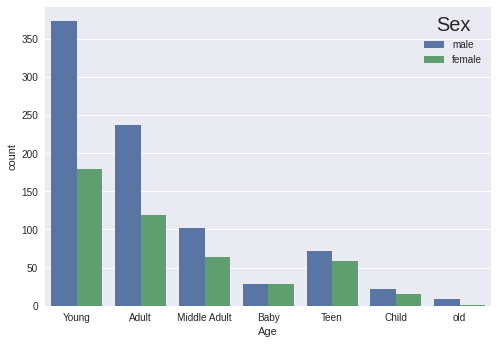

In [164]:
sns.countplot(x='Age', hue='Sex', data=all_data)

## **피처 스케일링**

### **Fare**

'Fare' 피처는 왜도가 큽니다. 넘파이의 `log()` 메서드를 적용하여 로그 변환을 수행하겠습니다. 언더 플로우를 방지하기 위해 `log1p()` 메서드를 사용하는 편이 좋지만 일단 그대로 적용해 보겠습니다.

In [165]:
all_data['Fare'] = all_data['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

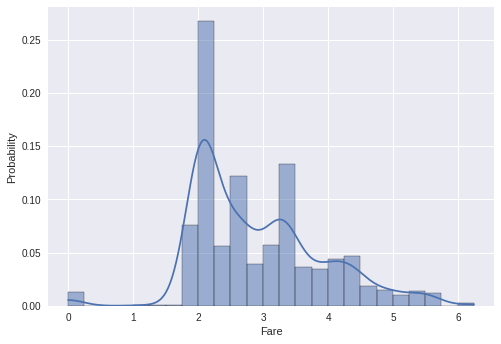

In [166]:
sns.histplot(x=all_data['Fare'], kde=True, stat='probability')

## **불필요한 피처 처리**

분석에 불필요한 피처는 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'입니다. 제거하겠습니다.

In [167]:
drop_feature_list = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket']
all_data = all_data.drop(drop_feature_list, axis=1)

In [168]:
all_data.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Appellation,Sum_sibsp_parch
0,0.0,3,male,Young,1.981001,S,Mr,1
1,1.0,1,female,Adult,4.266662,C,Mrs,1
2,1.0,3,female,Young,2.070022,S,Miss,0


## **카테고리 피처 처리**

### **원-핫 인코딩**

'Sex'와 'Embarked' 피처는 명목형 피처이므로 원-핫 인코딩을 적용할 필요가 있습니다. `OneHotEncoder()` 클래스는 명목형 피처와 순위형 피처 모두 원-핫 인코딩을 수행하고, 판다스의 `get_dummies()` 메서드는 명목형 피처만 원-핫 인코딩을 수행합니다. 일단 `get_dummies()` 메서드를 적용하며, 'Pclass' 피처는 변환을 거치지 않고 그대로 사용해 보겠습니다.

In [169]:
all_data_ohe = pd.get_dummies(all_data)
all_data_ohe.head(3)

,Survived,Pclass,Fare,Sum_sibsp_parch,Sex_female,Sex_male,Age_Adult,Age_Baby,Age_Child,Age_Middle Adult,Age_Teen,Age_Young,Age_old,Embarked_C,Embarked_Q,Embarked_S,Appellation_Master,Appellation_Miss,Appellation_Mr,Appellation_Mrs
0,0.0,3,1.981001,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1.0,1,4.266662,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1.0,3,2.070022,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


이상 베이스라인 모델링을 위한 피처 엔지니어링을 마칩니다. 추후 성능 개선 과정에서 추가로 더 수행할 방법이 있을지 생각해 보겠습니다. 

# **모델 훈련**

## **데이터 분리**

모든 데이터 세트를 훈련 세트와 테스트 세트로 나누고 타깃값을 따로 분리하겠습니다.

In [233]:
# 훈련 세트 개수를 지정합니다.
train_num = len(train)

X_train_df = all_data_ohe[:train_num].drop('Survived', axis=1) # 훈련 세트를 지정합니다.
X_test_df = all_data_ohe[train_num:].drop('Survived', axis=1) # 테스트 세트를 지정합니다.
y_train_df = train['Survived'] # 타깃값을 지정합니다.

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_df, y_train_df, test_size=0.2,
                                                      random_state=11)

## **모델 훈련**

모델을 훈련하겠습니다. 우선 기본 파라미터로 진행합니다.

In [235]:
from sklearn.linear_model import LogisticRegression

# `LogisticRegression`을 적용합니다.
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train, y_train)

LogisticRegression()

In [236]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# `LightGBM`을 적용합니다.
lgbm_clf_model = LGBMClassifier()
lgbm_clf_model.fit(X_train, y_train)

# `XGBoost`를 적용합니다.
xgb_clf_model = XGBClassifier()
xgb_clf_model.fit(X_train, y_train)

XGBClassifier()

## **피처 중요도 확인**

피처 중요도를 확인해 보겠습니다.

In [237]:
lgbm_clf_model.feature_importances_

array([  99, 1446,  193,   49,   32,  132,   21,    3,   28,   38,  174,
          0,   38,   38,   92,   27,   43,   64,   19])

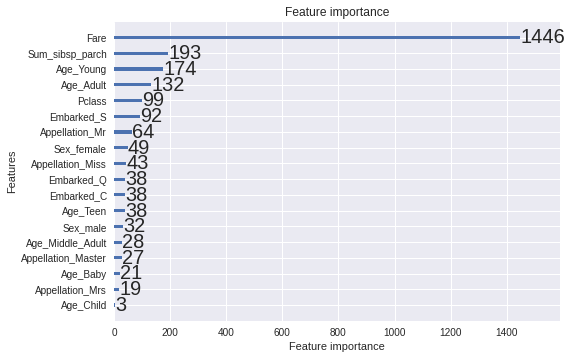

In [238]:
from lightgbm import plot_importance
plot_importance(lgbm_clf_model)

In [239]:
xgb_clf_model.feature_importances_

array([0.18097356, 0.02861219, 0.03986319, 0.01162815, 0.        ,
       0.01758045, 0.01619191, 0.        , 0.01713596, 0.03092047,
       0.02077246, 0.        , 0.01797362, 0.01543062, 0.02157547,
       0.03269035, 0.005756  , 0.5428956 , 0.        ], dtype=float32)

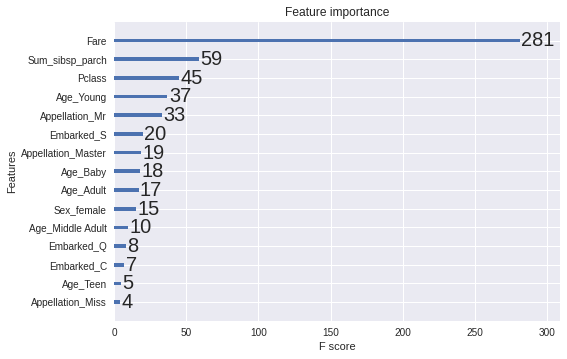

In [240]:
from xgboost import plot_importance
plot_importance(xgb_clf_model)

# **성능 검증**

성능을 검증해 보겠습니다. 먼저 `LogisticRegression`을 검증하겠습니다.

In [241]:
from sklearn.metrics import accuracy_score

y_pred_logistic_reg = logistic_reg_model.predict(X_valid)
accuracy_score(y_valid, y_pred_logistic_reg)

0.8659217877094972

`LightGBM`을 검증하겠습니다.

In [242]:
y_pred_lgbm_clf = lgbm_clf_model.predict(X_valid)
accuracy_score(y_valid, y_pred_lgbm_clf)

0.8770949720670391

`XGBoost`를 검증하겠습니다.

In [243]:
y_pred_xgb_clf = xgb_clf_model.predict(X_valid)
accuracy_score(y_valid, y_pred_xgb_clf)

0.88268156424581

`XGBoost` 성능이 가장 높습니다. 

K-폴드 교차 검증을 수행하는 함수를 생성하여 교차 검증을 수행해 보겠습니다. 

In [244]:
from sklearn.model_selection import KFold

def kfold_function(clf, folds=5):
    kfold = KFold(n_splits=folds)
    scores = []
    
    for iter_count, (train_index, val_index) in enumerate(kfold.split(X_train_df)):
        X_train, X_valid = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
        y_train, y_valid = y_train_df.iloc[train_index], y_train_df.iloc[val_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_valid)
        accuracy = accuracy_score(y_valid, predictions)
        scores.append(accuracy)
        print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count+1, accuracy))
        
    mean_score = np.mean(scores)
    print()
    print('평균 정확도: {0:.4f}'.format(mean_score))

`LogisticRegression`을 교차 검증 하겠습니다.

In [245]:
kfold_function(logistic_reg_model, folds=5)

교차 검증 1 정확도: 0.7989
교차 검증 2 정확도: 0.8258
교차 검증 3 정확도: 0.8034
교차 검증 4 정확도: 0.7921
교차 검증 5 정확도: 0.8820

평균 정확도: 0.8205


`LightGBM`을 교차 검증 하겠습니다.

In [246]:
kfold_function(lgbm_clf_model, folds=5)

교차 검증 1 정확도: 0.7821
교차 검증 2 정확도: 0.8090
교차 검증 3 정확도: 0.8820
교차 검증 4 정확도: 0.7921
교차 검증 5 정확도: 0.8764

평균 정확도: 0.8283


`XGBoost`를 교차 검증 하겠습니다.

In [247]:
kfold_function(xgb_clf_model, folds=5)

교차 검증 1 정확도: 0.8212
교차 검증 2 정확도: 0.8202
교차 검증 3 정확도: 0.8315
교차 검증 4 정확도: 0.7978
교차 검증 5 정확도: 0.8483

평균 정확도: 0.8238


Stratified K 폴드 교차 검증을 수행해 보겠습니다. `cross_val_score()` 메서드를 사용하겠습니다. 먼저 `LogisticRegression`을 교차 검증 하겠습니다.

In [248]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic_reg_model, X_train_df, y_train_df, scoring='accuracy', cv=5)
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4}'.format(iter_count+1, accuracy))

print()

print('평균 정확도: {:.4f}'.format(np.mean(scores)))

교차 검증 1 정확도: 0.8101
교차 검증 2 정확도: 0.8202
교차 검증 3 정확도: 0.809
교차 검증 4 정확도: 0.809
교차 검증 5 정확도: 0.8596

평균 정확도: 0.8216


`LightGBM`을 교차 검증 하겠습니다.

In [249]:
scores = cross_val_score(lgbm_clf_model, X_train_df, y_train_df, scoring='accuracy', cv=5)
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4}'.format(iter_count+1, accuracy))

print()

print('평균 정확도: {:.4f}'.format(np.mean(scores)))

교차 검증 1 정확도: 0.8156
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.8876
교차 검증 4 정확도: 0.7978
교차 검증 5 정확도: 0.8708

평균 정확도: 0.8328


`XGBoost`를 교차 검증 하겠습니다.

In [250]:
scores = cross_val_score(xgb_clf_model, X_train_df, y_train_df, scoring='accuracy', cv=5)
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4}'.format(iter_count+1, accuracy))

print()

print('평균 정확도: {:.4f}'.format(np.mean(scores)))

교차 검증 1 정확도: 0.8101
교차 검증 2 정확도: 0.8146
교차 검증 3 정확도: 0.8483
교차 검증 4 정확도: 0.809
교차 검증 5 정확도: 0.8427

평균 정확도: 0.8249


먼저 `XGBoost` 모델을 사용하여 모델 5개를 학습하고 최종적으로 예측해 보겠습니다. 먼저 모델을 학습하고 생성하는 함수를 선언하겠습니다.

In [251]:
def kfold_makes_models(clf, folds=5):
    models = []
    kfold = KFold(n_splits=folds)
    
    for train_index, val_index in kfold.split(X_train_df):
        X_train, X_valid = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
        y_train, y_valid = y_train_df.iloc[train_index], y_train_df.iloc[val_index]
        clf.fit(X_train, y_train)
        models.append(clf)

    return models

모델 5개를 생성하겠습니다.

In [252]:
xgb_clf_models = kfold_makes_models(xgb_clf_model)

생성한 모델 5개로 테스트 세트를 예측하겠습니다.

In [262]:
predictions = []
for model in xgb_clf_models:
    prediction = model.predict(X_test_df)
    predictions.append(prediction)

리스트 객체 `predictions`에는 아래와 같이 예측 결괏값이 담긴 5개 리스트가 담깁니다. 확인해 보겠습니다.

In [271]:
predictions

[array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

리스트 5개의 동일한 위치에 있는 각 값을 평균하여 하나의 값으로 만들어야 합니다. 넘파이 배열로 변환하면 평균값을 산출할 수 있습니다. 넘파이 배열로 변환하겠습니다.

In [273]:
predictions_to_array = np.array(predictions)
predictions_to_array

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

각 값을 평균하겠습니다.

In [276]:
predictions_mean = np.mean(predictions_to_array, axis=0)
predictions_mean

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [278]:
type(predictions_mean[0])

numpy.float64

각 값의 타입은 `float64`입니다. `int`로 변환할 필요가 있습니다. `0.5` 이상을 생존으로 고정하겠습니다.

In [281]:
predictions_to_int = (predictions_mean > 0.5).astype(int)
predictions_to_int

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

제출 파일에 생존여부 피처를 추가하여 예측한 값으로 치환하겠습니다.

In [282]:
submission['Survived'] = predictions_to_int
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


제출 파일을 생성하겠습니다.

In [283]:
submission.to_csv('Titanic_submission_1.csv', index=False)

퍼블릭 스코어는 0.76315입니다. 만족할 만한 수준은 아닙니다.

이번엔 교차 검증 결과로 평균 정확도가 가장 높은 `LightGBM` 모델을 사용하여 동일한 과정을 수행해 보겠습니다.

In [284]:
lgbm_clf_models = kfold_makes_models(lgbm_clf_model)

predictions = []
for model in lgbm_clf_models:
    prediction = model.predict(X_test_df)
    predictions.append(prediction)

predictions_to_array = np.array(predictions)
predictions_mean = np.mean(predictions_to_array, axis=0)
predictions_to_int = (predictions_mean > 0.5).astype(int)

submission['Survived'] = predictions_to_int
submission.to_csv('Titanic_submission_2.csv', index=False)

퍼블릭 스코어는 0.7488입니다. `XGBoost`보다 낮습니다.

마지막으로 `LogisticRegression` 모델을 사용하여 동일한 과정을 수행해 보겠습니다.

In [285]:
logistic_reg_models = kfold_makes_models(logistic_reg_model)

predictions = []
for model in logistic_reg_models:
    prediction = model.predict(X_test_df)
    predictions.append(prediction)

predictions_to_array = np.array(predictions)
predictions_mean = np.mean(predictions_to_array, axis=0)
predictions_to_int = (predictions_mean > 0.5).astype(int)

submission['Survived'] = predictions_to_int
submission.to_csv('Titanic_submission_3.csv', index=False)

퍼블릭 스코어는 0.77272입니다. 오히려 위의 두 모델보다 점수가 약간 높으나 만족스러운 수준은 아닙니다.

성능 개선 챕터에서 여러 작업을 더 수행해 보겠습니다. 추가 피처 엔지니어링, 하이퍼파라미터 최적화 등 시도할 수 있는 작업이 많습니다.